This notebook produces Fig3b of the Batty et al, paper. The figure is an example showing how the maximum genomic separation and local separation metrics are calculated, using the WT and NIPBL depletion data published in Mitter 2020.

In [1]:
import seaborn as sbn
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import subprocess
import ipywidgets as widgets
from ipywidgets import interact

from ngs import HiCTools as HT


ATTENTION: You need to run a high memory kernel

TODO: Figure out why this des not work for pbgzip!

In [2]:
import shutil
shutil.which('pbgzip')   
shutil.which('lz4c')

#Since pairtools/_fileio.py checks for this
#if shutil.which('pbgzip') is None:
#            raise ValueError({
#                'w':'pbgzip is not found, cannot compress output',
#                'a':'pbgzip is not found, cannot compress output',
#                'r':'pbgzip is not found, cannot decompress input'
#                    }[mode])

'/opt/conda/bin/lz4c'

Remark: I made a copy of ther *pairs.gz into unzip/ (to be save because our gzip version is <1.6 and has no -k flag). And this script now only works with unzipped pairsam files until IT installs pbgzip since in the jupyter kernel will not find the version installed with conda. Or we rewrite Antons tool to use a different bzip. (would be in pairtools/_fileio.py)

Now we will load the data:

In [3]:
#use of the merged G2 pairs file in this case instead of the individual replicates

pairDir = {"G2": "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/cis_trans_pairs_g2/unzipped/",
           "nipbl_dep_CCGTCC_S1" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GTCCGC_S2" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GTGAAA_S3" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GTGGCC_S4" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GTTTCG_S5" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_CGTACG_S6" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GAGTGG_S7" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_GGTAGC_S8" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_ACTGAT_S9" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/",
           "nipbl_dep_ATGAGC_S10" : "/groups/gerlich/experiments/Experiments_004900/004911/s4t_merged_pairsam/unzip/"
          }


sampleMapping = {"G2" : "G2_WT", 
                 "nipbl_dep_CCGTCC_S1" : "NIPBL_dep_G2_rep1",
                 "nipbl_dep_GTCCGC_S2" : "NIPBL_dep_G2_rep2",
                 "nipbl_dep_GTGAAA_S3" : "NIPBL_dep_G2_rep3",
                 "nipbl_dep_GTGGCC_S4" : "NIPBL_dep_G2_rep4",
                 "nipbl_dep_GTTTCG_S5" : "NIPBL_dep_G2_rep5",
                 "nipbl_dep_CGTACG_S6" : "NIPBL_dep_G2_rep6",
                 "nipbl_dep_GAGTGG_S7" : "NIPBL_dep_G2_rep7",
                 "nipbl_dep_GGTAGC_S8" : "NIPBL_dep_G2_rep8",
                 "nipbl_dep_ACTGAT_S9" : "NIPBL_dep_G2_rep9",
                 "nipbl_dep_ATGAGC_S10" : "NIPBL_dep_G2_rep10"
                 }

pairs = {}
for barcode, name in sampleMapping.items():
    pairs[name] = {}
    pairs[name]["cis"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.cis.pairs"))
    pairs[name]["trans"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.trans.pairs"))

Merge replicates of different samples

In [4]:
pairsMerged = {}
pairsMerged["G2_WT"] = {}
pairsMerged["G2_WT"]["cis"] = pairs["G2_WT"]["cis"]
pairsMerged["G2_WT"]["trans"]=pairs["G2_WT"]["trans"]

pairsMerged["NIPBL_depletion"] = {}
pairsMerged["NIPBL_depletion"]["cis"] = pd.concat((pairs["NIPBL_dep_G2_rep1"]["cis"], pairs["NIPBL_dep_G2_rep2"]["cis"], pairs["NIPBL_dep_G2_rep3"]["cis"], pairs["NIPBL_dep_G2_rep4"]["cis"], pairs["NIPBL_dep_G2_rep5"]["cis"], pairs["NIPBL_dep_G2_rep6"]["cis"], pairs["NIPBL_dep_G2_rep7"]["cis"], pairs["NIPBL_dep_G2_rep8"]["cis"], pairs["NIPBL_dep_G2_rep9"]["cis"], pairs["NIPBL_dep_G2_rep10"]["cis"]))
pairsMerged["NIPBL_depletion"]["trans"] = pd.concat((pairs["NIPBL_dep_G2_rep1"]["trans"], pairs["NIPBL_dep_G2_rep2"]["trans"], pairs["NIPBL_dep_G2_rep3"]["trans"], pairs["NIPBL_dep_G2_rep4"]["trans"], pairs["NIPBL_dep_G2_rep5"]["trans"], pairs["NIPBL_dep_G2_rep6"]["trans"], pairs["NIPBL_dep_G2_rep7"]["trans"], pairs["NIPBL_dep_G2_rep8"]["trans"], pairs["NIPBL_dep_G2_rep9"]["trans"], pairs["NIPBL_dep_G2_rep10"]["trans"]))



Prepare data for plotting:

In [5]:
#ndistbins set to 60 instead of 40 to more accurately calculate the interesection point in cis/trans ratio plots
# downsample pairs --> use this if you have multiple samples
# then pairs needs to be a nested dictionary {sample: {cis: pairFrame, trans:pairFrame}}

downsampled = HT.down_sample_pairs(pairsMerged, distance=1000)

# get chromosome features

hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.get_arms_hg19()

# calculate scaling plots

scs = {sample: {rType: pairlib.scalings.compute_scaling(
       downsampled[sample][rType],
       arms,
       hg19_chromsizes, n_dist_bins=60
       ) for rType in ["cis", "trans"]}
       for sample in downsampled.keys()}


# aggregate scaling plots

sc_agg = {sample: {rType: (scs[sample][rType][0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
          for rType in scs[sample].keys()
          } for sample in scs.keys()
          }

# calculate x-Values and contact probability

plotData = {sample: {rType: (np.sqrt(sc_agg[sample][rType].min_dist * sc_agg[sample][rType].max_dist),
            sc_agg[sample][rType].n_pairs / sc_agg[sample][rType].n_bp2)
            for rType in sc_agg[sample].keys()
            } for sample in sc_agg.keys()
                        }





/users/paul.batty/.conda/envs/cooltools/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
for sample in plotData.keys():
    for rtype in ["cis"], ["trans"]:
        #make dataframes from scalings
        bins = plotData[sample]["cis"][0]
        cis = plotData[sample]["cis"][1]
        trans = plotData[sample]["trans"][1]
        ratio = plotData[sample]["cis"][1]/plotData[sample]["trans"][1]
        series_list = (bins, cis, trans, ratio)
        cis_trans_ratios = pd.concat(series_list, axis=1)
        cis_trans_ratios.columns = ['bins', 'cis_contact_prob', 'trans_contact_prob','cis/trans_ratio']
        cis_trans_ratios["condition"] = f'{sample}'
        #remove last row
        cis_trans_ratios = cis_trans_ratios.iloc[:-1 , :]
        resultsdir = "/groups/gerlich/labinfo/Papers/2023_Batty_et_al/emboj_revised_submission/fig_by_fig_emboj_revised_manuscript/main_figures/fig5/panel_a/"
        cis_trans_ratios.to_csv(os.path.join(resultsdir, f"{sample}.csv"), index=False)

Setup apearance for plots

In [12]:
#new colour map with black and red instead of grays

In [13]:
cmap = {"cis": "black",
            "trans": "red"}

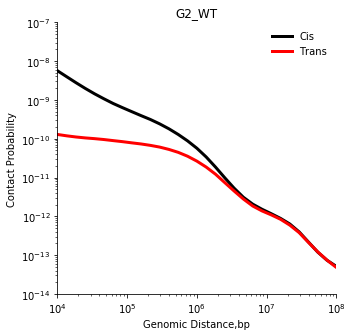

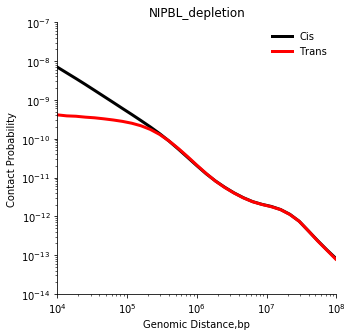

In [14]:
for sample in plotData.keys():
    f, ax = plt.subplots(1,1)
    for rType in ["cis", "trans"]:
        ax.loglog(plotData[sample][rType][0],
                plotData[sample][rType][1],
                label=f'{rType.capitalize()}', color=cmap[rType], lw=3
                )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 100000000)
    ax.set_ylim(10**(-14), 10**(-7))
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Contact Probability")
    f.set_size_inches(5,5)
    sbn.despine()
    plt.title(sample)
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig3/scalings/"
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.png"), bbox_inches="tight")
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.pdf"), bbox_inches="tight")


In [15]:
cmap2 = {"G2_WT": "black",
            "NIPBL_depletion": "red"}

<b>Plot log log cis/trans ratio vs genomic distance <b>

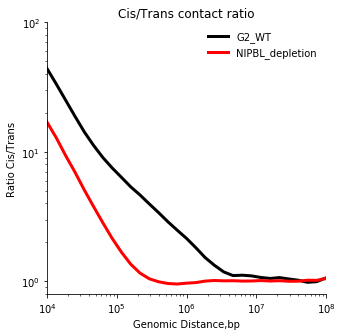

In [18]:
f, ax = plt.subplots(1,1)
for sample in plotData.keys():
    for rType in ["trans"]:
        if sample == "G2_WT" or sample == "NIPBL_depletion":
            ax.loglog(plotData[sample][rType][0],
                    plotData[sample]["cis"][1]/plotData[sample][rType][1],
                    label=f'{sample}', color=cmap2[sample], lw=3
                    )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 100000000)
    ax.set_ylim(0.8, 100)
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Ratio Cis/Trans")
    f.set_size_inches(5,5)
    sbn.despine()
    plt.title('Cis/Trans contact ratio')
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/scalings/"
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log log.png"), bbox_inches="tight")
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log log.pdf"), bbox_inches="tight")


<b>Plot lin log vs genomic distance<b>

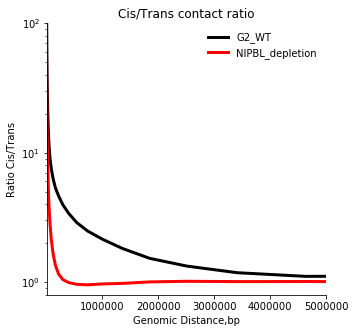

In [19]:
f, ax = plt.subplots(1,1)
for sample in plotData.keys():
    for rType in ["trans"]:
        if sample == "G2_WT" or sample == "NIPBL_depletion":
            ax.semilogy(plotData[sample][rType][0],
                    plotData[sample]["cis"][1]/plotData[sample][rType][1],
                    label=f'{sample}', color=cmap2[sample], lw=3
                    )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 5000000)
    ax.set_ylim(0.8, 100)
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Ratio Cis/Trans")
    f.set_size_inches(5,5)
    sbn.despine()
    plt.title('Cis/Trans contact ratio')
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/scalings/"
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 lin log.png"), bbox_inches="tight")
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 lin log.pdf"), bbox_inches="tight")


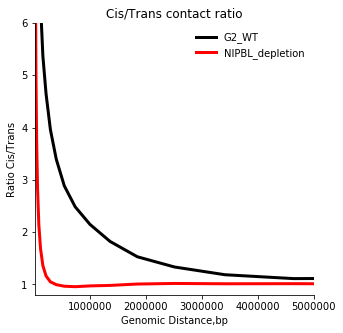

In [20]:
f, ax = plt.subplots(1,1)
for sample in plotData.keys():
    for rType in ["trans"]:
        if sample == "G2_WT" or sample == "NIPBL_depletion":
            ax.plot(plotData[sample][rType][0],
                    plotData[sample]["cis"][1]/plotData[sample][rType][1],
                    label=f'{sample}', color=cmap2[sample], lw=3
                    )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 5000000)
    ax.set_ylim(0.8, 6)
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Ratio Cis/Trans")
    f.set_size_inches(5,5)
    sbn.despine()
    plt.title('Cis/Trans contact ratio')
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/scalings/"
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 lin log.png"), bbox_inches="tight")
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 lin log.pdf"), bbox_inches="tight")


<b>Plot log lin vs genomic distance<b>

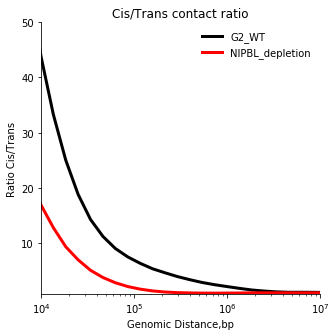

In [21]:
f, ax = plt.subplots(1,1)
for sample in plotData.keys():
    for rType in ["trans"]:
        if sample == "G2_WT" or sample == "NIPBL_depletion":
            ax.semilogx(plotData[sample][rType][0],
                    plotData[sample]["cis"][1]/plotData[sample][rType][1],
                    label=f'{sample}', color=cmap2[sample], lw=3
                    )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 10000000)
    ax.set_ylim(0.8, 50)
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Ratio Cis/Trans")
    f.set_size_inches(5,5)
    sbn.despine()
    plt.title('Cis/Trans contact ratio')
    f.show()
    resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/scalings/"
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log lin.png"), bbox_inches="tight")
    f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log lin.pdf"), bbox_inches="tight")


In [22]:
#Plot log lin vs genomic distance

<b> Calculate genomic distance at which cis contact probability equals trans contact probability (threshold = 1.2 to account for noise)<b>

G2_WT : 3.414549e+06
NIPBL_depletion : 2.154436e+05


Text(0.5, 1.0, 'Maximum distance of genomic resolution')

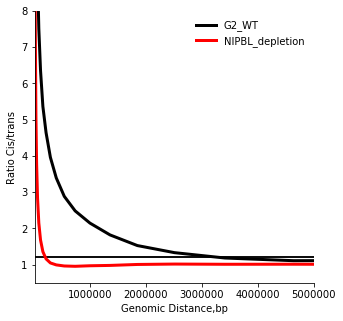

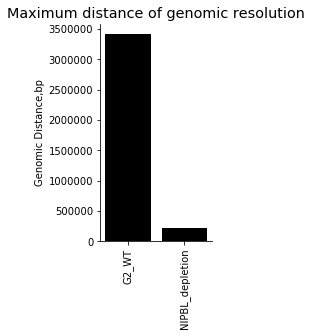

In [23]:
    f, ax = plt.subplots(1,1)
    intersects = []
    a = 1.2
    for sample in plotData.keys():
        for rType in ["trans"]:
            ax.plot(plotData[sample][rType][0],
                    plotData[sample]["cis"][1]/plotData[sample]["trans"][1],
                    label=f'{sample}',  color=cmap2[sample], lw=3
                    )
            helper = plotData[sample]["cis"][1]/plotData[sample]["trans"][1]
            for index, y_value in enumerate(helper):
                if (y_value < a):
                    print(sample + " : {0:e}".format(plotData[sample][rType][0][index]))
                          #+ " @ " + str(y_value))
                    intersects.append(plotData[sample][rType][0][index])
                if (y_value < a):
                    break
            ax.hlines(a, 10000, 10000000)    
        #print(a)    
        ax.grid(lw=0.5, color='gray')
        ax.grid(False)
        ax.set_xlim(10000, 5000000)
        ax.set_ylim(0.5, 8)
        ax.legend(frameon=False)
        ax.set_xlabel("Genomic Distance,bp")
        ax.set_ylabel("Ratio Cis/trans")
        f.set_size_inches(5,5)
        sbn.despine()
        #plt.title('Cis/trans contact ratio all conditions')
        f.show()
        resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/scalings/"
        #f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log log with threshold.png"), bbox_inches="tight")
        #f.savefig(os.path.join(resultsdir, "Cis over trans WT, NIPBL dep G2 log log with threshold.pdf"), bbox_inches="tight")
    f1, ax2 = plt.subplots(1,1)
    ax2.bar(plotData.keys(), intersects, color = "black") 
    f1.set_size_inches(2,4)
    ax2.tick_params(axis = 'x', rotation=90)
    sbn.despine()
    #ax2.set_ylim(0, 9000000)
    ax2.set_ylabel("Genomic Distance,bp")
    plt.rcParams.update({'font.size': 12})
    plt.title('Maximum distance of genomic resolution')